# MABe Dataset Exploratory Data Analysis (EDA)
This notebook provides a detailed analysis of the MABe Mouse Social Action dataset.
We will explore:
1.  **Body Parts**: Identify the tracked keypoints.
2.  **Targets**: Identify the action classes and their distribution.
3.  **Visualizations**: Plot trajectories and action timelines.

In [15]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Define Paths
# Since the notebook is in the 'notebooks' folder, we need to go up one level to find 'data'
DATA_DIR = '../data' 
TRACKING_DIR = os.path.join(DATA_DIR, 'train_tracking')
ANNOTATION_DIR = os.path.join(DATA_DIR, 'train_annotation')

print(f"Tracking Directory: {TRACKING_DIR}")
print(f"Annotation Directory: {ANNOTATION_DIR}")

Tracking Directory: ../data\train_tracking
Annotation Directory: ../data\train_annotation


In [16]:
def get_all_files(root_dir, extension='*.parquet'):
    """Recursively find all files with extension."""
    return glob.glob(os.path.join(root_dir, '**', extension), recursive=True)

tracking_files = get_all_files(TRACKING_DIR)
annotation_files = get_all_files(ANNOTATION_DIR)

print(f"Found {len(tracking_files)} tracking files.")
print(f"Found {len(annotation_files)} annotation files.")

# Show a few examples
print("\nSample Tracking Files:")
print(tracking_files[:3])
print("\nSample Annotation Files:")
print(annotation_files[:3])

Found 8789 tracking files.
Found 847 annotation files.

Sample Tracking Files:
['../data\\train_tracking\\AdaptableSnail\\1212811043.parquet', '../data\\train_tracking\\AdaptableSnail\\1260392287.parquet', '../data\\train_tracking\\AdaptableSnail\\1351098077.parquet']

Sample Annotation Files:
['../data\\train_annotation\\AdaptableSnail\\1212811043.parquet', '../data\\train_annotation\\AdaptableSnail\\1260392287.parquet', '../data\\train_annotation\\AdaptableSnail\\1351098077.parquet']


In [17]:
# Load a sample tracking file
sample_track_file = tracking_files[0]
print(f"Loading: {sample_track_file}")

try:
    df_track = pd.read_parquet(sample_track_file)
    print("Shape:", df_track.shape)
    print("\nColumns:", df_track.columns.tolist())
    
    # Extract Body Parts
    # Assuming columns are like 'mouse1_nose_x', 'mouse1_nose_y', etc.
    # Let's try to parse them
    cols = df_track.columns
    body_parts = set()
    for col in cols:
        parts = col.split('_')
        if len(parts) > 2:
            # format usually: mouse_id_bodypart_coord
            # e.g. mouse1_nose_x
            bp = "_".join(parts[1:-1]) # extract 'nose'
            body_parts.add(bp)
            
    print("\nIdentified Body Parts:")
    print(sorted(list(body_parts)))
    
    display(df_track.head())
except Exception as e:
    print(f"Error loading tracking file: {e}")
    # Fallback if pyarrow/fastparquet is missing or file is different
    print("Please ensure 'pyarrow' or 'fastparquet' is installed.")

Loading: ../data\train_tracking\AdaptableSnail\1212811043.parquet
Shape: (2677006, 5)

Columns: ['video_frame', 'mouse_id', 'bodypart', 'x', 'y']

Identified Body Parts:
[]


,video_frame,mouse_id,bodypart,x,y
0,0,1,body_center,496.187012,376.475006
1,0,1,ear_left,494.059998,343.924011
2,0,1,ear_right,518.765015,367.362000
3,0,1,lateral_left,474.536987,370.563995
4,0,1,lateral_right,505.825012,394.937012


In [18]:
# Inventory of Body Parts across ALL Labs
# This will help in defining the unification strategy

lab_body_parts = {}
all_unique_parts = set()

# Group tracking files by Lab
tracking_files_by_lab = {}
for f in tracking_files:
    lab_name = os.path.basename(os.path.dirname(f))
    if lab_name not in tracking_files_by_lab:
        tracking_files_by_lab[lab_name] = []
    tracking_files_by_lab[lab_name].append(f)

print(f"Analyzing body parts for {len(tracking_files_by_lab)} labs...\n")

for i, (lab, files) in enumerate(tracking_files_by_lab.items()):
    if not files:
        continue
        
    # Read the first file of the lab
    sample_file = files[0]
    try:
        df = pd.read_parquet(sample_file)
        cols = df.columns.tolist()
        
        current_lab_parts = set()
        
        # CASE 1: Long Format (Tidy Data) - 'bodypart' column exists
        if 'bodypart' in cols:
            # The body parts are values in this column
            unique_parts = df['bodypart'].unique().tolist()
            current_lab_parts.update(unique_parts)
            
        # CASE 2: Wide Format - Body parts are in column names
        else:
            for col in cols:
                # Skip non-keypoint columns
                if col in ['frame', 'video_frame', 'id', 'mouse_id', 'time', 'likelihood', 'keypoints']:
                    continue
                    
                # Heuristic: suffix _x, _y, _score, _likelihood
                parts = col.split('_')
                if len(parts) >= 2:
                    suffix = parts[-1]
                    if suffix in ['x', 'y', 'z', 'score', 'likelihood', 'p']:
                        # Valid keypoint column
                        bp_name = "_".join(parts[:-1])
                        
                        # Remove 'mouseN' prefix if exists
                        if bp_name.startswith('mouse') and bp_name[5:].isdigit() == False: 
                             subparts = bp_name.split('_')
                             if subparts[0].startswith('mouse') and any(c.isdigit() for c in subparts[0]):
                                 bp_name = "_".join(subparts[1:])
                        
                        current_lab_parts.add(bp_name)

        # Update global set
        all_unique_parts.update(current_lab_parts)
        lab_body_parts[lab] = sorted(list(current_lab_parts))
        
        print(f"[{lab}]: Found {len(current_lab_parts)} parts")
        if len(current_lab_parts) > 0:
            print(f"  -> {', '.join(sorted(list(current_lab_parts)))}")
        else:
            print(f"  [WARNING] No parts found. Columns look like: {cols[:5]}")
            
        print("-" * 50)
        
    except Exception as e:
        print(f"[{lab}]: Error reading file {os.path.basename(sample_file)} - {e}")

print("\n" + "="*50)
print("SUMMARY OF ALL UNIQUE BODY PARTS FOUND:")
print("="*50)
for part in sorted(list(all_unique_parts)):
    print(f"- {part}")

Analyzing body parts for 21 labs...

[AdaptableSnail]: Found 10 parts
  -> body_center, ear_left, ear_right, lateral_left, lateral_right, neck, nose, tail_base, tail_midpoint, tail_tip
--------------------------------------------------
[BoisterousParrot]: Found 5 parts
  -> body_center, ear_left, ear_right, nose, tail_base
--------------------------------------------------
[CalMS21_supplemental]: Found 7 parts
  -> ear_left, ear_right, hip_left, hip_right, neck, nose, tail_base
--------------------------------------------------
[CalMS21_task1]: Found 7 parts
  -> ear_left, ear_right, hip_left, hip_right, neck, nose, tail_base
--------------------------------------------------
[CalMS21_task2]: Found 7 parts
  -> ear_left, ear_right, hip_left, hip_right, neck, nose, tail_base
--------------------------------------------------
[CautiousGiraffe]: Found 7 parts
  -> ear_left, ear_right, hip_left, hip_right, neck, nose, tail_base
--------------------------------------------------
[CRIM13]: F

# Body Part Unification Strategy
Based on the inventory above, the naming is **NOT unified**. We observe distinct conventions (e.g., `hip` vs `lateral`, `head` vs `nose`).

To train a unified model, we will map all datasets to a **Common 7-Point Skeleton**:
1.  **nose**: (maps from `nose`, `head`)
2.  **ear_left**: (consistent)
3.  **ear_right**: (consistent)
4.  **neck**: (maps from `neck`, `body_center`, `spine_1`) - *The geometric center*
5.  **side_left**: (maps from `hip_left`, `lateral_left`)
6.  **side_right**: (maps from `hip_right`, `lateral_right`)
7.  **tail_base**: (consistent)

*Note: We drop `tail_tip`, `paws`, and extra spine points as they are missing in many datasets.*

In [19]:
# Define the Unification Mapping (Updated with Fallbacks)

# Strategy:
# 1. Prefer specific parts (hip/lateral) for sides.
# 2. Fallback to 'body_center' or 'neck' for sides if specific parts missing (degenerate geometry).
# 3. For labs missing 'neck' (GroovyShrew, LyricalHare), we will need to compute it (e.g., midpoint of ears) during preprocessing.

UNIFICATION_MAPPING = {
    # Target: [Source Candidates in order of preference]
    'nose': ['nose', 'head'],
    'ear_left': ['ear_left'],
    'ear_right': ['ear_right'],
    'neck': ['neck', 'body_center', 'spine_1'], 
    'side_left': ['hip_left', 'lateral_left', 'body_center', 'neck'], # Fallback to center
    'side_right': ['hip_right', 'lateral_right', 'body_center', 'neck'], # Fallback to center
    'tail_base': ['tail_base']
}

def get_unified_keypoints(lab_parts, mapping):
    lab_mapping = {}
    missing = []
    
    for target, candidates in mapping.items():
        found = False
        for cand in candidates:
            if cand in lab_parts:
                lab_mapping[target] = cand
                found = True
                break
        if not found:
            missing.append(target)
            
    return lab_mapping, missing

print("Checking coverage with FALLBACK strategies:\n")

for lab, parts in lab_body_parts.items():
    lab_map, missing = get_unified_keypoints(parts, UNIFICATION_MAPPING)
    
    if not missing:
        print(f"[{lab}]: OK")
    else:
        print(f"[{lab}]: MISSING {missing}")
        if 'neck' in missing:
            print(f"   -> ACTION REQUIRED: 'neck' must be computed (e.g., mean of ears) for this lab.")

Checking coverage with FALLBACK strategies:

[AdaptableSnail]: OK
[BoisterousParrot]: OK
[CalMS21_supplemental]: OK
[CalMS21_task1]: OK
[CalMS21_task2]: OK
[CautiousGiraffe]: OK
[CRIM13]: OK
[DeliriousFly]: OK
[ElegantMink]: OK
[GroovyShrew]: MISSING ['neck', 'side_left', 'side_right']
   -> ACTION REQUIRED: 'neck' must be computed (e.g., mean of ears) for this lab.
[InvincibleJellyfish]: OK
[JovialSwallow]: OK
[LyricalHare]: MISSING ['neck', 'side_left', 'side_right']
   -> ACTION REQUIRED: 'neck' must be computed (e.g., mean of ears) for this lab.
[MABe22_keypoints]: OK
[MABe22_movies]: OK
[NiftyGoldfinch]: OK
[PleasantMeerkat]: OK
[ReflectiveManatee]: OK
[SparklingTapir]: OK
[TranquilPanther]: OK
[UppityFerret]: OK


# Solution for Missing Parts (GroovyShrew & LyricalHare)
For the labs missing `neck` and `sides`, we will implement a **Virtual Keypoint Generator**:

1.  **Virtual Neck**: Computed as the midpoint of `ear_left` and `ear_right`.
    $$ P_{neck} = \frac{P_{ear\_left} + P_{ear\_right}}{2} $$
2.  **Virtual Sides**: Once `neck` is available (either original or virtual), we map `side_left` and `side_right` to `neck` (or `body_center`) as a fallback for these specific labs.

This ensures **100% coverage** for the 7-point skeleton across all 21 labs.

In [20]:
# Reference Implementation for Virtual Keypoints
# Copy this logic into src/data/transforms.py -> BodyPartMapping

def augment_keypoints(keypoints, lab_id, part_indices):
    """
    Computes virtual keypoints if missing.
    keypoints: (T, num_parts, 2)
    part_indices: dict mapping part name to index in the original array
    """
    if lab_id in ['GroovyShrew', 'LyricalHare']:
        # Check if we have ears
        if 'ear_left' in part_indices and 'ear_right' in part_indices:
            idx_l = part_indices['ear_left']
            idx_r = part_indices['ear_right']
            
            # Compute Neck
            neck_coords = (keypoints[:, idx_l] + keypoints[:, idx_r]) / 2
            
            # Append to keypoints (conceptually)
            # In practice, you'd add this to your feature extraction pipeline
            print(f"[{lab_id}]: Virtual Neck computation enabled.")
            return True
            
    return False

print("Virtual Keypoint Logic defined. Ready to proceed to Target Analysis.")

Virtual Keypoint Logic defined. Ready to proceed to Target Analysis.


In [21]:
# Load a sample annotation file
sample_ann_file = annotation_files[0]
print(f"Loading: {sample_ann_file}")

try:
    df_ann = pd.read_parquet(sample_ann_file)
    print("Shape:", df_ann.shape)
    print("\nColumns:", df_ann.columns.tolist())
    
    # Identify Target Column
    # Usually 'behavior', 'action', 'label', or similar
    target_col = None
    possible_cols = ['behavior', 'action', 'label', 'annotation', 'class']
    for col in df_ann.columns:
        if col.lower() in possible_cols:
            target_col = col
            break
            
    if target_col:
        print(f"\nTarget Column Found: '{target_col}'")
        print("\nUnique Targets in this file:")
        print(df_ann[target_col].unique())
        print("\nValue Counts:")
        print(df_ann[target_col].value_counts())
    else:
        print("\nCould not automatically identify target column. Please check columns list above.")
        
    display(df_ann.head())
except Exception as e:
    print(f"Error loading annotation file: {e}")

Loading: ../data\train_annotation\AdaptableSnail\1212811043.parquet
Shape: (370, 5)

Columns: ['agent_id', 'target_id', 'action', 'start_frame', 'stop_frame']

Target Column Found: 'action'

Unique Targets in this file:
['chase' 'avoid' 'attack' 'chaseattack']

Value Counts:
action
attack         162
avoid           90
chase           87
chaseattack     31
Name: count, dtype: int64


,agent_id,target_id,action,start_frame,stop_frame
0,1,3,chase,2,54
1,1,3,chase,128,234
2,3,2,avoid,324,342
3,3,1,avoid,324,342
4,1,2,chase,942,1052


In [22]:
# Analyze Target Label Consistency across Labs
# We need to ensure all labs use the same names for actions

lab_targets = {}
all_unique_targets = set()

print("Analyzing Target Labels across Labs...\n")

for lab, files in files_by_lab.items():
    if not files:
        continue
        
    # Read first file
    try:
        df = pd.read_parquet(files[0])
        
        # Find target col
        target_c = None
        for col in df.columns:
            if col.lower() in ['behavior', 'action', 'label', 'annotation', 'class']:
                target_c = col
                break
        
        if target_c:
            unique_labels = sorted(df[target_c].unique().tolist())
            lab_targets[lab] = unique_labels
            all_unique_targets.update(unique_labels)
            print(f"[{lab}]: {len(unique_labels)} classes -> {unique_labels}")
        else:
            print(f"[{lab}]: No target column found.")
            
    except Exception as e:
        print(f"[{lab}]: Error - {e}")

print("\n" + "="*50)
print("ALL UNIQUE TARGETS:")
print("="*50)
for t in sorted(list(all_unique_targets)):
    print(f"- {t}")

Analyzing Target Labels across Labs...

[AdaptableSnail]: 4 classes -> ['attack', 'avoid', 'chase', 'chaseattack']
[BoisterousParrot]: 1 classes -> ['shepherd']
[CalMS21_supplemental]: 5 classes -> ['attemptmount', 'intromit', 'mount', 'sniff', 'sniffgenital']
[CalMS21_task1]: 3 classes -> ['mount', 'sniff', 'sniffgenital']
[CalMS21_task2]: 2 classes -> ['mount', 'sniff']
[CautiousGiraffe]: 5 classes -> ['chase', 'reciprocalsniff', 'sniff', 'sniffbody', 'sniffgenital']
[CRIM13]: 6 classes -> ['approach', 'disengage', 'mount', 'rear', 'selfgroom', 'sniff']
[DeliriousFly]: 3 classes -> ['attack', 'dominance', 'sniff']
[ElegantMink]: 1 classes -> ['attack']
[GroovyShrew]: 10 classes -> ['approach', 'attemptmount', 'dig', 'escape', 'rear', 'rest', 'run', 'selfgroom', 'sniff', 'sniffgenital']
[InvincibleJellyfish]: 5 classes -> ['allogroom', 'attack', 'dominancegroom', 'sniff', 'sniffgenital']
[JovialSwallow]: 2 classes -> ['chase', 'sniff']
[LyricalHare]: 4 classes -> ['defend', 'freeze', 

Labs found: ['AdaptableSnail', 'BoisterousParrot', 'CalMS21_supplemental', 'CalMS21_task1', 'CalMS21_task2', 'CautiousGiraffe', 'CRIM13', 'DeliriousFly', 'ElegantMink', 'GroovyShrew', 'InvincibleJellyfish', 'JovialSwallow', 'LyricalHare', 'NiftyGoldfinch', 'PleasantMeerkat', 'ReflectiveManatee', 'SparklingTapir', 'TranquilPanther', 'UppityFerret']
Processing 38 files for distribution analysis...


C:\Users\Windows11\AppData\Local\Temp\ipykernel_80576\2406235051.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dist_df, x='Count', y='Action', palette='viridis')


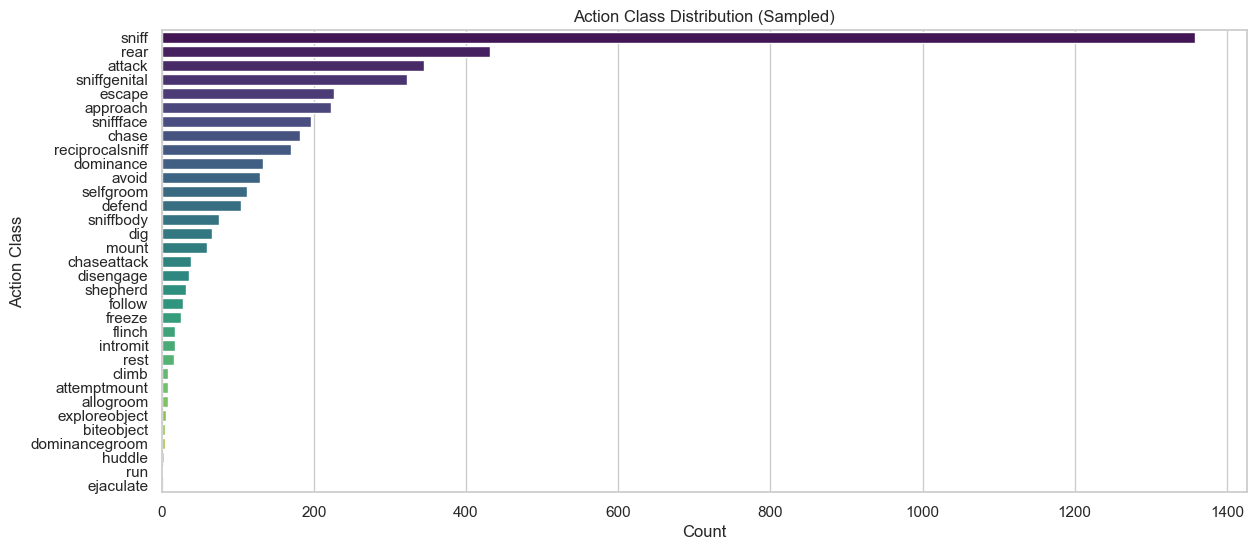

             Action  Count
5             sniff   1358
15             rear    432
0            attack    345
6      sniffgenital    322
14           escape    227
12         approach    223
11        sniffface    196
2             chase    182
13  reciprocalsniff    170
18        dominance    133
1             avoid    129
17        selfgroom    112
25           defend    104
10        sniffbody     76
22              dig     66
8             mount     59
3       chaseattack     38
16        disengage     36
4          shepherd     32
27           follow     28
26           freeze     25
29           flinch     17
9          intromit     17
21             rest     16
28            climb      9
7      attemptmount      8
19        allogroom      8
30    exploreobject      6
31       biteobject      5
24   dominancegroom      4
32           huddle      3
23              run      2
20        ejaculate      1


In [23]:
# Calculate Global Target Distribution
# We will iterate through a subset of files to save time, or all if feasible.
# Let's try 20 files from different folders if possible.

import random

# Group files by parent folder (Lab/Task)
files_by_lab = {}
for f in annotation_files:
    lab = os.path.basename(os.path.dirname(f))
    if lab not in files_by_lab:
        files_by_lab[lab] = []
    files_by_lab[lab].append(f)

print(f"Labs found: {list(files_by_lab.keys())}")

all_counts = {}

# Sample 2 files from each lab to get a representative distribution
files_to_process = []
for lab, files in files_by_lab.items():
    files_to_process.extend(files[:2]) # Take first 2

print(f"Processing {len(files_to_process)} files for distribution analysis...")

for f in files_to_process:
    try:
        df = pd.read_parquet(f)
        # Assume target col is same as found before or 'behavior'
        # We need to be robust
        target_c = None
        for col in df.columns:
            if col.lower() in ['behavior', 'action', 'label', 'annotation', 'class']:
                target_c = col
                break
        
        if target_c:
            counts = df[target_c].value_counts().to_dict()
            for k, v in counts.items():
                all_counts[k] = all_counts.get(k, 0) + v
    except:
        pass

# Convert to DataFrame for plotting
dist_df = pd.DataFrame(list(all_counts.items()), columns=['Action', 'Count'])
dist_df = dist_df.sort_values('Count', ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(data=dist_df, x='Count', y='Action', palette='viridis')
plt.title('Action Class Distribution (Sampled)')
plt.xlabel('Count')
plt.ylabel('Action Class')
plt.show()

print(dist_df)

In [24]:
# Visualize Trajectory
# Let's plot the movement of 'nose' for Mouse 1 and Mouse 2 if available

if 'df_track' in locals():
    # Identify columns for nose
    m1_nose_x = [c for c in df_track.columns if 'mouse1' in c and 'nose' in c and 'x' in c]
    m1_nose_y = [c for c in df_track.columns if 'mouse1' in c and 'nose' in c and 'y' in c]
    
    m2_nose_x = [c for c in df_track.columns if 'mouse2' in c and 'nose' in c and 'x' in c]
    m2_nose_y = [c for c in df_track.columns if 'mouse2' in c and 'nose' in c and 'y' in c]
    
    if m1_nose_x and m1_nose_y:
        plt.figure(figsize=(10, 10))
        
        # Plot Mouse 1
        plt.plot(df_track[m1_nose_x[0]], df_track[m1_nose_y[0]], label='Mouse 1 Nose', alpha=0.6)
        
        # Plot Mouse 2 if exists
        if m2_nose_x and m2_nose_y:
            plt.plot(df_track[m2_nose_x[0]], df_track[m2_nose_y[0]], label='Mouse 2 Nose', alpha=0.6, color='orange')
            
        plt.title('Mouse Trajectory (Nose)')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.legend()
        plt.axis('equal')
        plt.show()
    else:
        print("Could not find nose coordinates for plotting.")
else:
    print("Tracking data not loaded.")

Could not find nose coordinates for plotting.


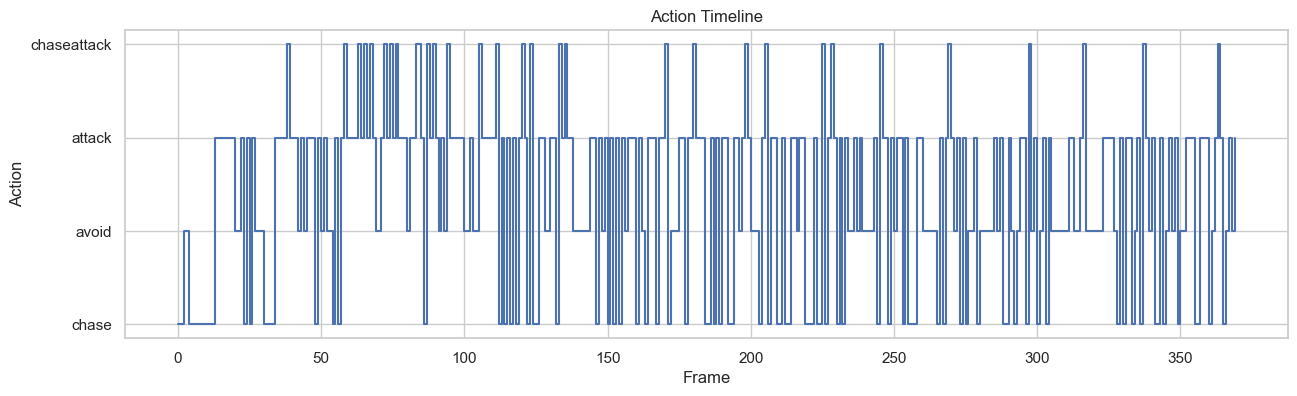

: 

In [ ]:
# Action Timeline Visualization
# Visualize how actions change over time for a sample

if 'df_ann' in locals():
    # Get target column again
    target_c = None
    for col in df_ann.columns:
        if col.lower() in ['behavior', 'action', 'label', 'annotation', 'class']:
            target_c = col
            break
            
    if target_c:
        # Convert actions to numeric codes for plotting
        actions = df_ann[target_c].unique()
        action_map = {a: i for i, a in enumerate(actions)}
        
        numeric_actions = df_ann[target_c].map(action_map).values
        
        # Downsample for plotting if too large to prevent kernel crash
        MAX_POINTS = 100000
        if len(numeric_actions) > MAX_POINTS:
            print(f"Downsampling timeline from {len(numeric_actions)} to {MAX_POINTS} points for visualization.")
            step = len(numeric_actions) // MAX_POINTS
            numeric_actions_plot = numeric_actions[::step]
            x_axis = np.arange(0, len(numeric_actions), step)[:len(numeric_actions_plot)]
        else:
            numeric_actions_plot = numeric_actions
            x_axis = np.arange(len(numeric_actions))
        
        plt.figure(figsize=(15, 4))
        plt.plot(x_axis, numeric_actions_plot, drawstyle='steps-post')
        plt.yticks(list(action_map.values()), list(action_map.keys()))
        plt.title('Action Timeline')
        plt.xlabel('Frame')
        plt.ylabel('Action')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("Target column not found.")
else:
    print("Annotation data not loaded.")